In [1]:
pwd

'/Users/edwardterrell/Desktop/Training/kindle/strava'

In [9]:
import requests
import json
import time
import os
from pprint import pprint
import pandas as pd
pd.set_option('display.precision', 1)

%load_ext autoreload
%autoreload 2
from clean_convert import cleanup, convert_speed, order_columns


from IPython.core.display import HTML
with open("style-table.css") as f1, open("style-notebook.css") as f2:
    css = f1.read() + f2.read()
HTML(f"<style>{css}</style>")

import sys
sys.executable

'/Users/edwardterrell/opt/anaconda3/envs/mlml/bin/python'

In [3]:
from token_manager import get_valid_access_token

access_token = get_valid_access_token()
print("Using access token:", access_token)

# Make an authenticated API call
response = requests.get(
    'https://www.strava.com/api/v3/athlete',
    headers={'Authorization': f'Bearer {access_token}'}
)
print(response.json())

Using access token: 8e5e6a3dd85ce84a4003a72c0a7b1b163bb2d747
{'id': 723727, 'username': 'eterrell', 'resource_state': 2, 'firstname': 'Ed', 'lastname': 'Terrell', 'bio': '', 'city': 'Boulder', 'state': 'CO', 'country': 'United States', 'sex': 'M', 'premium': True, 'summit': True, 'created_at': '2012-07-05T00:04:09Z', 'updated_at': '2025-07-09T12:38:59Z', 'badge_type_id': 1, 'weight': 61.235, 'profile_medium': 'https://dgalywyr863hv.cloudfront.net/pictures/athletes/723727/20826329/1/medium.jpg', 'profile': 'https://dgalywyr863hv.cloudfront.net/pictures/athletes/723727/20826329/1/large.jpg', 'friend': None, 'follower': None}


In [4]:
# Get recent activities
response = requests.get(
    'https://www.strava.com/api/v3/athlete/activities',
    headers={'Authorization': f'Bearer {access_token}'}
)
activities = response.json()
#response.status_code

# Show the first 3 activities with ID and name
for activity in activities[:3]:
    print(f"ID: {activity['id']}, Name: {activity['name']}, Date: {activity['start_date']}")

ID: 15061307314, Name: Nederland exploration and exploitation, Date: 2025-07-09T14:17:28Z
ID: 15048399185, Name: Jamestown and eats at Lucky's Bakery, Date: 2025-07-08T14:44:02Z
ID: 15037283785, Name: Old Stage, Date: 2025-07-07T12:38:38Z


### Build strava_df from activities

In [19]:
# Build out strava_df with only the necessary columns
strava_df = pd.DataFrame(activities)
cols_needed = ['id','name', 'distance', 'moving_time','total_elevation_gain', 'sport_type',
          'average_speed', 'average_heartrate','max_heartrate', 'suffer_score','start_date']
strava_df = strava_df.loc[:,cols_needed]
strava_df.head()

,id,name,distance,moving_time,total_elevation_gain,sport_type,average_speed,average_heartrate,max_heartrate,suffer_score,start_date
0,15061307314,Nederland exploration and exploitation,54140.4,11638,993.7,Ride,4.7,109.1,131.0,106.0,2025-07-09T14:17:28Z
1,15048399185,Jamestown and eats at Lucky's Bakery,60380.4,9467,757.0,Ride,6.4,110.9,140.0,101.0,2025-07-08T14:44:02Z
2,15037283785,Old Stage,44640.8,7128,430.0,Ride,6.3,109.6,134.0,54.0,2025-07-07T12:38:38Z
3,15027982989,North dirt roads to Longmont bike paths and Ba...,59511.9,10021,361.6,Ride,5.9,102.5,129.0,47.0,2025-07-06T14:14:42Z
4,15017668877,Base of LickSkillet++,75306.7,13372,1087.6,Ride,5.6,109.9,141.0,117.0,2025-07-05T13:55:37Z


In [20]:
# drop activities where no heartrate data was collected
strava_df = strava_df.dropna(subset=['average_heartrate'])
#strava_df.head(2)

# process data with function cleanup (from clean_convert.py)
cleanup (strava_df)

# add column: converted_speed ride-mph  and run-min/mile  (from clean_convert.py)
strava_df['converted_speed'] = strava_df.apply(convert_speed, axis=1)

In [21]:
strava_df = order_columns(strava_df)
strava_df.head(2)

,id,name,date,sport,distance,time,speed,elev_gain,avg_HR,max_HR,suffer_score,time-minutes,average_speed,start_date
0,15061307314,Nederland exploration and exploitation,2025-07-09,Ride,33.6,3:13,10.4,3260.2,109.1,131.0,106.0,194.0,4.7,2025-07-09 14:17:28+00:00
1,15048399185,Jamestown and eats at Lucky's Bakery,2025-07-08,Ride,37.5,2:37,14.3,2483.6,110.9,140.0,101.0,157.8,6.4,2025-07-08 14:44:02+00:00


### Dataframe approach to create strava_zone_df

In [31]:
# Create a zone dataframe
cols = ['id', 'name', 'date', 'suffer_score','start_date']
#data = strava_df.iloc[:,[0,1,2,-4,-1]]
data = strava_df.loc[:,cols]
strava_zone_df = pd.DataFrame(data, columns=cols)
strava_zone_df.tail(1)

,id,name,date,suffer_score,start_date
29,14621663272,The Long Way Home,2025-05-28,230.0,2025-05-28 13:18:10+00:00


In [32]:
# activity ID to inspect
# activity_id = 15048399185

def get_zones_for_id(activity_id):
    print(activity_id)
    url = f'https://www.strava.com/api/v3/activities/{activity_id}/zones'
    # Set up Authorization header and make request
    headers = {'Authorization': f'Bearer {access_token}'}
    response = requests.get(url, headers=headers)

    # Check if the request was successful
    if response.status_code == 200:
        zones = response.json()
    else:
        print(f"Error: {response.status_code}")
        print(response.text)
    # create time_in_zones series
    zone_series  = pd.DataFrame(zones[0]).iloc[:,1]
    time_in_zones = zone_series.apply(lambda z: z['time']/60)
    time_in_zones.index = ['Zone1', 'Zone2', 'Zone3', 'Zone4', 'Zone5']
    time.sleep(.8)
    return (time_in_zones)

In [33]:
zone_df = strava_zone_df['id'].apply(get_zones_for_id)

# Add in summary zones: moderate and intense
zone_df['moderate'] = zone_df[['Zone1', 'Zone2']].sum(axis=1)
zone_df['intense'] = zone_df[['Zone3', 'Zone4', 'Zone5']].sum(axis=1)
# zone_df.head()
# concat both dfs
strava_zone_df = pd.concat([strava_zone_df, zone_df], axis=1)

15061307314
15048399185
15037283785
15027982989
15017668877
15006491752
14975645989
14964904782
14954454448
14944687171
14934728422
14925456666
14915319034
14873916201
14860197741
14854414147
14840593381
14767120578
14758807206
14748055178
14737389332
14727760782
14715424784
14705554493
14694429401
14684468262
14672337121
14666228613
14621663272


In [183]:
strava_zone_df.drop(['intense_min_weekly','moderate_min_weekly'], axis=1, inplace=True)

In [184]:
# Get the Sunday start of the week for each date (time set to midnight)
strava_zone_df['week_start'] = strava_zone_df['start_date'].dt.to_period('W-SUN').dt.start_time

/Users/edwardterrell/opt/anaconda3/envs/mlml/lib/python3.8/site-packages/pandas/core/arrays/datetimes.py:1101: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


In [185]:
strava_zone_df.head(5)

,id,name,date,suffer_score,start_date,Zone1,Zone2,Zone3,Zone4,Zone5,moderate,intense,week_start
0,15061307314,Nederland exploration and exploitation,2025-07-09,106.0,2025-07-09 14:17:28+00:00,31.9,132.7,29.4,0.0,0.0,164.6,29.4,2025-07-07
1,15048399185,Jamestown and eats at Lucky's Bakery,2025-07-08,101.0,2025-07-08 14:44:02+00:00,21.4,109.4,26.1,0.8,0.0,130.8,26.9,2025-07-07
2,15037283785,Old Stage,2025-07-07,54.0,2025-07-07 12:38:38+00:00,2.6,104.8,11.4,0.0,0.0,107.3,11.4,2025-07-07
3,15027982989,North dirt roads to Longmont bike paths and Ba...,2025-07-06,47.0,2025-07-06 14:14:42+00:00,16.4,149.1,1.5,0.0,0.0,165.5,1.5,2025-06-30
4,15017668877,Base of LickSkillet++,2025-07-05,117.0,2025-07-05 13:55:37+00:00,18.0,195.0,8.5,1.4,0.0,212.9,9.9,2025-06-30


In [188]:
# Temporarily sort ascending by week_start and date to compute cumulative sum correctly
temp = strava_zone_df.sort_values(['week_start', 'start_date'], ascending=[True, True])

# Calculate cumulative sum within each week
temp['intense_minutes'] = temp.groupby('week_start')['intense'].cumsum()

# Merge cumulative sum back to original DataFrame order
strava_zone_df = strava_zone_df.merge(
    temp[['intense_minutes']],
    left_index=True, right_index=True
)

In [189]:
# Temporarily sort ascending by week_start and date to compute cumulative sum correctly
temp = strava_zone_df.sort_values(['week_start', 'start_date'], ascending=[True, True])

# Calculate cumulative sum within each week
temp['moderate_minutes'] = temp.groupby('week_start')['moderate'].cumsum()

# Merge cumulative sum back to original DataFrame order
strava_zone_df = strava_zone_df.merge(
    temp[['moderate_minutes']],
    left_index=True, right_index=True
)

In [227]:
# Temporarily sort ascending by week_start and date to compute cumulative sum correctly
temp = strava_zone_df.sort_values(['week_start', 'start_date'], ascending=[True, True])

# Calculate cumulative sum within each week
temp['suffer_score_week'] = temp.groupby('week_start')['suffer_score'].cumsum()

# Merge cumulative sum back to original DataFrame order
strava_zone_df = strava_zone_df.merge(
    temp[['suffer_score_week']],
    left_index=True, right_index=True
)

In [230]:
hide_cols = ['id', 'name', 'date', 'suffer_score', 'moderate', 'intense',
       'intense_minutes','moderate_minutes','suffer_score_week']

In [231]:
strava_zone_df[hide_cols].head(4)

,id,name,date,suffer_score,moderate,intense,intense_minutes,moderate_minutes,suffer_score_week
0,15061307314,Nederland exploration and exploitation,2025-07-09,106.0,164.6,29.4,67.8,402.8,261.0
1,15048399185,Jamestown and eats at Lucky's Bakery,2025-07-08,101.0,130.8,26.9,38.4,238.2,155.0
2,15037283785,Old Stage,2025-07-07,54.0,107.3,11.4,11.4,107.3,54.0
3,15027982989,North dirt roads to Longmont bike paths and Ba...,2025-07-06,47.0,165.5,1.5,143.9,794.7,597.0


In [232]:
weekly_summary = (
    strava_zone_df
    .groupby('week_start')[['intense_minutes','moderate_minutes','suffer_score_week']]
    .max()
    .reset_index()
)

# Format weeks as strings (e.g. 'Jul 01', 'Jul 08')
weekly_summary["week"] = weekly_summary["week_start"].dt.strftime('%b %d')
weekly_summary.head(3)

,week_start,intense_minutes,moderate_minutes,suffer_score_week,week
0,2025-05-26,215.0,151.1,511.0,May 26
1,2025-06-02,411.2,553.2,992.0,Jun 02
2,2025-06-09,95.1,292.5,287.0,Jun 09


In [233]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(14,8)}) # for all future plots

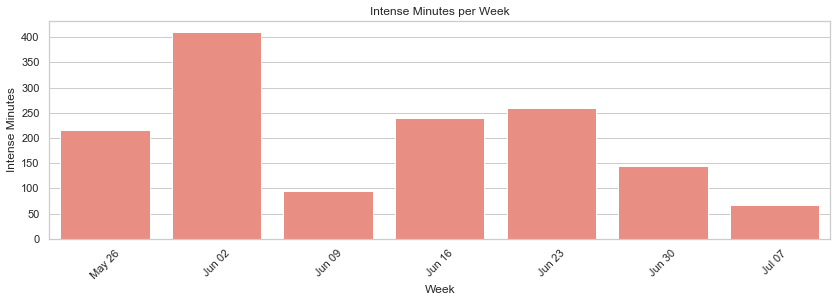

In [235]:
# Plot using seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(14, 4))
# ax = sns.lineplot(data=weekly_summary, x='week_start', y='intense', marker='o')
ax = sns.barplot(x="week", y="intense_minutes", data=weekly_summary, color="salmon")
# Rotate and label
plt.xticks(rotation=45);
ax.set_title("Intense Minutes per Week")
ax.set_ylabel("Intense Minutes")
ax.set_xlabel("Week");

In [236]:
# Melt the DataFrame to long format
long_df = pd.melt(
    weekly_summary,
    id_vars="week",
    value_vars=["intense_minutes", "moderate_minutes"],
    var_name="zone",
    value_name="minutes"
)
long_df.head()

,week,zone,minutes
0,May 26,intense_minutes,215.0
1,Jun 02,intense_minutes,411.2
2,Jun 09,intense_minutes,95.1
3,Jun 16,intense_minutes,240.2
4,Jun 23,intense_minutes,259.7


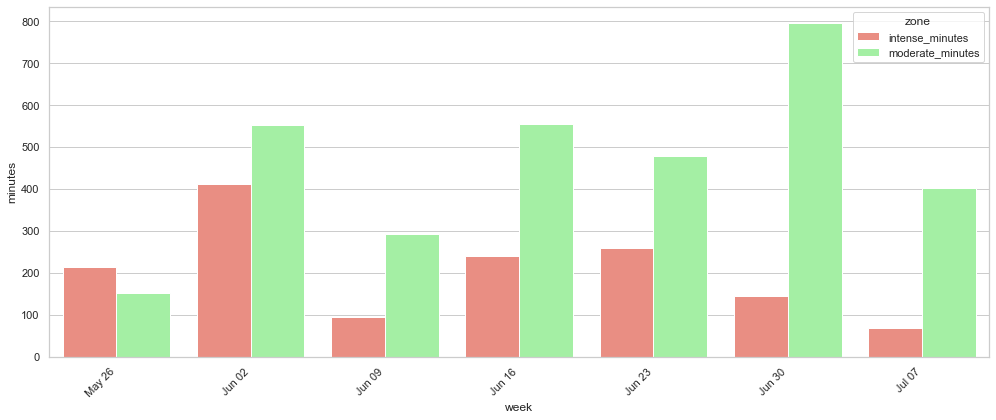

In [238]:
plt.figure(figsize=(14, 6))
ax = sns.barplot(
    data=long_df,
    x="week",
    y="minutes",
    hue="zone",
    palette={"intense_minutes": "salmon", "moderate_minutes": "palegreen"}
)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

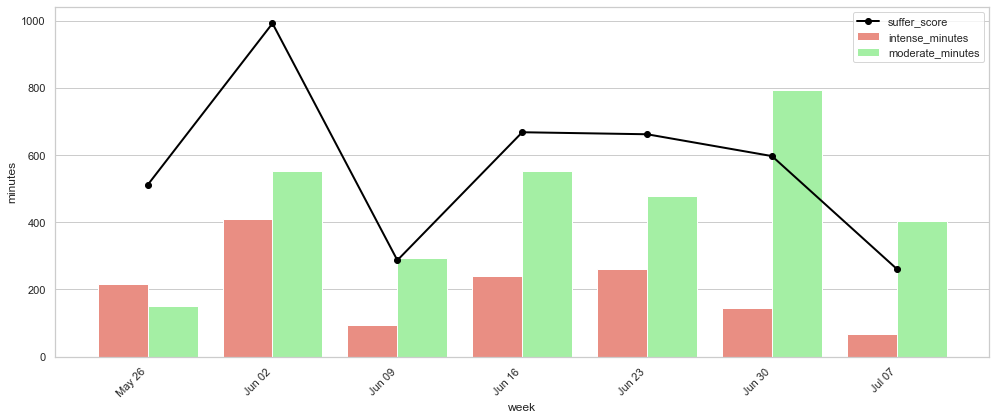

In [240]:
# Add a line plot on top 
plt.figure(figsize=(14, 6))
# Add line plot with a label
ax = sns.barplot(
    data=long_df,
    x="week",
    y="minutes",
    hue="zone",
    palette={"intense_minutes": "salmon", "moderate_minutes": "palegreen"}
)
line = ax.plot(
    weekly_summary["week"],
    weekly_summary["suffer_score_week"],
    color="black",
    marker="o",
    linewidth=2,
    label="suffer_score"  # this is essential
)
# Create the legend manually from all handles
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels)

# Optional: improve layout
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
#plt.legend()
plt.show()

In [ ]:
# Sample Data
df = pd.DataFrame({
    "week": pd.date_range("2024-01-01", periods=12, freq="W-MON"),
    "value": range(12)
})
df